In [8]:
import pennylane as qml
import numpy as nnp
import jax
import jax.numpy as np
import numpy as nnp 
import random
import matplotlib.pyplot as plt

In [9]:
  dev_cf = qml.device("default.mixed",wires=9)

  def qnp_layer(params,wires,evenorodd="odd"): 
      if evenorodd=="odd":
          qml.SingleExcitation(params[0], wires=[wires[1],wires[2]])
          qml.SingleExcitation(params[1], wires=[wires[0],wires[3]])
      elif evenorodd=="even":
          qml.SingleExcitation(params[0], wires=[wires[0],wires[1]])
          qml.SingleExcitation(params[1], wires=[wires[2],wires[3]])
      else:
          raise NotImplementedError()
            
  def noise_layer(p,wires):
    for wire in wires:
        #qml.DepolarizingChannel(p, wires=wire)
        qml.AmplitudeDamping(p, wire)
        qml.PhaseDamping(p, wire)
        # qml.PauliError("X",p, wires=wire)

  def qnp_ansatz(params,p,wires):
    qnp_layer(params[0:2],wires,evenorodd="odd")
    noise_layer(p,wires)
    qnp_layer(params[2:4],wires,evenorodd="even")
    noise_layer(p,wires)
    qml.DoubleExcitation(params[4],wires=wires)
    noise_layer(p,wires)
    qnp_layer(params[5:7],wires,evenorodd="odd")
    noise_layer(p,wires)
    qnp_layer(params[7:9],wires,evenorodd="even")
    noise_layer(p,wires)

  def qnp_ansatz_adj(params,p,wires):
    qnp_layer(-params[7:9],wires,evenorodd="even")
    noise_layer(p,wires)
    qnp_layer(-params[5:7],wires,evenorodd="odd")
    noise_layer(p,wires)
    qml.DoubleExcitation(-params[4],wires=wires)
    noise_layer(p,wires)
    qnp_layer(-params[2:4],wires,evenorodd="even")
    noise_layer(p,wires)
    qnp_layer(-params[0:2],wires,evenorodd="odd")
    noise_layer(p,wires)



  @qml.qnode(dev_cf, interface="jax")
  def swap_test_cf(params, is1or0=0,noswaps=False, fidelity=False, p=0.01, measureZ=False, postselect=False, obs_wire=0):
      wires=nnp.array(range(9))
      qml.PauliX(0)
      qml.PauliX(1)
      qml.PauliX(4)
      qml.PauliX(5)
      qml.Hadamard(8)

      qnp_ansatz(params[0:9],p,wires[0:4])
      qnp_ansatz(params[9:18],p,wires[0:4])
      qnp_ansatz(params[18:27],p,wires[0:4])
      qnp_ansatz(params[0:9],p,wires[4:8])
      qnp_ansatz(params[9:18],p,wires[4:8])
      qnp_ansatz(params[18:27],p,wires[4:8])
      if not fidelity:
        if not noswaps:
          for x,y in zip(wires[0:4],wires[4:8]):
              qml.CSWAP(wires=[8,x,y])
      # make evolution
        if measureZ:
          qml.CZ( wires=[8,obs_wire])
      qnp_ansatz_adj(params[18:27],p,wires[0:4])
      qnp_ansatz_adj(params[9:18],p,wires[0:4])
      qnp_ansatz_adj(params[0:9],p,wires[0:4])
      qnp_ansatz_adj(params[18:27],p,wires[4:8])
      qnp_ansatz_adj(params[9:18],p,wires[4:8])
      qnp_ansatz_adj(params[0:9],p,wires[4:8])

      qml.PauliX(0)
      qml.PauliX(1)
      qml.PauliX(4)
      qml.PauliX(5)
      qml.Hadamard(8)
      if not postselect:
        if is1or0==0:
          return qml.expval(qml.Projector([0],wires=8))
        elif is1or0==1:
          return qml.expval(qml.Projector([1],wires=8))
        else:
          raise NotImplementedError()
      else:
        # if not fidelity:
          # qml.PauliX(8)
        if not noswaps:
          if is1or0==0:
            return qml.expval(qml.Projector([0,0,0,0,0,0,0,0,0],wires=range(9)))
          elif is1or0==1:
            return qml.expval(qml.Projector([0,0,0,0,0,0,0,0,1],wires=range(9)))
          else:
            raise NotImplementedError()
        else:
          if is1or0==0:
            return qml.expval(qml.Projector([0,0,0,0,0],wires=[0,1,2,3,8]))
          elif is1or0==1:
            return qml.expval(qml.Projector([0,0,0,0,1],wires=[0,1,2,3,8]))
          else:
            raise NotImplementedError()


  def estimator_virt_dist(params,p, obs_wire=0, denom_only=False):
    if not denom_only:
      nominator = (2*swap_test_cf(params, p=p, measureZ=True, obs_wire=obs_wire)-1)
    denominator = (2*swap_test_cf(params, p=p, measureZ=False, obs_wire=obs_wire  )-1)
    if denom_only:
        return denominator
    return nominator/denominator

  def estimator_virt_dist_math(params,p,obs_wire=0, denom_only=False):
    if not denom_only:
      a = swap_test_cf(params, is1or0=0, p=p, measureZ=True, postselect=True, obs_wire=obs_wire)
      b = swap_test_cf(params, is1or0=1, p=p, measureZ=True, postselect=True, obs_wire=obs_wire)
      numerator = (a-b)
    a = swap_test_cf(params, is1or0=0, p=p, measureZ=False, postselect=True, obs_wire=obs_wire)
    b = swap_test_cf(params, is1or0=1, p=p, measureZ=False, postselect=True, obs_wire=obs_wire)
    denominator = (a-b)
    if denom_only:
        denominator = (a+b)
        return denominator
    return numerator/denominator

  def estimator_echo_ver(params,p, obs_wire=0, denom_only=False):
    if not denom_only:
      a = swap_test_cf(params, is1or0=0, p=p,noswaps=True, measureZ=True, postselect=True, obs_wire=obs_wire)
      b = swap_test_cf(params, is1or0=1, p=p,noswaps=True, measureZ=True, postselect=True, obs_wire=obs_wire)
      numerator = (a-b)
    a = swap_test_cf(params, is1or0=0, p=p,noswaps=True, measureZ=False, postselect=True, obs_wire=obs_wire)
    b = swap_test_cf(params, is1or0=1, p=p,noswaps=True, measureZ=False, postselect=True, obs_wire=obs_wire)
    denominator = (a-b)
    if denom_only:
        denominator = (a+b)
        return denominator
    return numerator/denominator

  dev_2 = qml.device("default.mixed",wires=4)
  @qml.qnode(dev_2)
  def measure_dens(params, p,wires=range(4)):
        qml.PauliX(0)
        qml.PauliX(1)
        qnp_ansatz(params[0:9],p,wires[0:4])
        qnp_ansatz(params[9:18],p,wires[0:4])
        qnp_ansatz(params[18:27],p,wires[0:4])
        return qml.state()


  def estimator_virt_dist_4(params,p,obs_wire=0):
      dens_matrix = measure_dens(params, p)
      identity = qml.matrix(qml.Identity(0))
      paulz = qml.matrix(qml.PauliZ(0))
      if obs_wire==0:
          obs = paulz
      else:
          obs = identity
      for x in range(1,4):
          if x == obs_wire:
            obs = np.kron(obs,paulz)
          else:
            obs = np.kron(obs,identity)
      rho_4 = measure_dens(params, p)
      for x in range(1,4):
        rho = measure_dens(params, p)
        rho_4 = np.dot(rho_4,rho)
      return np.real(np.trace(np.dot(obs,rho_4)) /np.trace(rho_4))

  def estimator_virt_dist_1(params,p, obs_wire=0):
      dev_2 = qml.device("default.mixed",wires=4)
      @qml.qnode(dev_2)
      def measure_test_n(params,p, wires=range(4)):
          qml.PauliX(0)
          qml.PauliX(1)
          qnp_ansatz(params[0:9],p,wires[0:4])
          qnp_ansatz(params[9:18],p,wires[0:4])
          qnp_ansatz(params[18:27],p,wires[0:4])

          return qml.expval(qml.PauliZ(obs_wire))
      return measure_test_n(params,p)

  def combined_estimator(estimator, obs_list, params, p):
          return sum([estimator(params, p, obs_wire=obs_wire) for obs_wire in obs_list])

  # print(estimator_virt_dist_math(params,0.2))
  params = np.array(nnp.random.random(27))*nnp.pi/2


In [20]:
  virt_dist, echo_ver, veri_virt, virt_dist_4, virt_dist_1 = [],[],[], [], []
  virt_dist_arr, echo_ver_arr, veri_virt_arr, virt_dist_4_arr, virt_dist_1_arr = [],[],[], [], []
  virt_dist_var, echo_ver_var, veri_virt_var, virt_dist_4_var, virt_dist_1_var = [],[],[], [], []

  var_arr = [virt_dist_var, echo_ver_var, veri_virt_var, virt_dist_4_var, virt_dist_1_var]
  mean_arr = [virt_dist_arr, echo_ver_arr, veri_virt_arr, virt_dist_4_arr, virt_dist_1_arr]
  current_arr = [virt_dist, echo_ver, veri_virt, virt_dist_4, virt_dist_1]

  params_arr = [np.pi*np.array(nnp.random.rand(*params.shape)) for x in range(40)]

  # obs_list = [0]
  obs_list_rand = [[0],[1],[2],[3],[0,1],[1,2],[2,3],[0,2],[1,3],[0,3]]
  obs_list_fix = [random.choice(obs_list_rand) for i in range(len(params_arr))]

  for p in np.logspace(-0.5, -3.5, num=30):
      print(p)
      obs_list = random.choice(obs_list_fix)
      virt_dist, echo_ver, veri_virt, virt_dist_4, virt_dist_1 = [],[],[], [], []
      var_arr = [virt_dist_var, echo_ver_var, veri_virt_var, virt_dist_4_var, virt_dist_1_var]
      for params_i,obs_list in zip(params_arr,obs_list_fix):
        anal_val= combined_estimator(estimator_virt_dist_1, obs_list, params_i,0)
        virt_dist.append(anal_val - combined_estimator(estimator_virt_dist,obs_list,params_i,p))
        veri_virt.append(anal_val - combined_estimator(estimator_virt_dist_math,obs_list,params_i,p))
        echo_ver.append(anal_val - combined_estimator(estimator_echo_ver,obs_list,params_i,p))
        virt_dist_4.append(anal_val - combined_estimator(estimator_virt_dist_4,obs_list,params_i,p))
        virt_dist_1.append(anal_val - combined_estimator(estimator_virt_dist_1,obs_list,params_i,p))
      # for x,y,z in zip(current_arr,mean_arr,var_arr):
      for x,y,z in zip(
              [virt_dist, echo_ver, veri_virt, virt_dist_4, virt_dist_1],
              [virt_dist_arr, echo_ver_arr, veri_virt_arr, virt_dist_4_arr, virt_dist_1_arr],
              [virt_dist_var, echo_ver_var, veri_virt_var, virt_dist_4_var, virt_dist_1_var]
      ):
          y.append(nnp.mean(nnp.array(x)))
          z.append(nnp.var(nnp.array(x)))
  print("Done")


0.31622776
0.14677991
0.0681292
0.031622767
0.014677991
0.0068129194
0.003162276
0.0014677987
0.0006812919
0.00031622776
Done


Text(0, 0.5, 'Absolute error to noiseless expectation value')

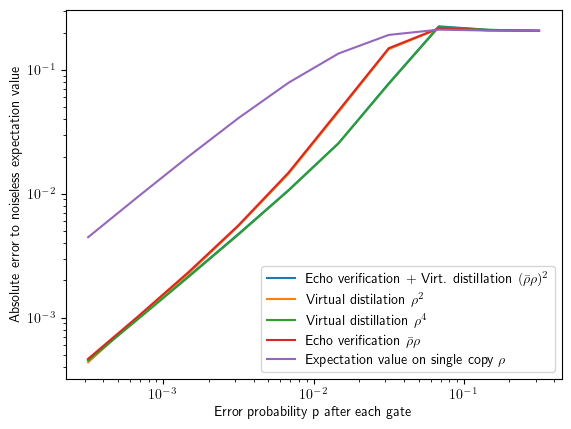

In [21]:
  plt.rcParams['text.usetex'] = True
  ps = np.logspace(-0.5, -3.5, num=10)
  fig, ax = plt.subplots()
  ax.plot(ps, abs(np.array(veri_virt_arr)), label=r"Echo verification + Virt. distillation $ (\bar{\rho} \rho)^2$")
  # ax.scatter(ps, abs(np.array(veri_virt)), label=r"Echo verification + Virt distillation $\frac{\operatorname{Tr}\left(O(\rho \bar{\rho})^M\right)}{\operatorname{Tr}\left((\rho \bar{\rho})^M\right)}$")
  ax.plot(ps, abs(np.array(virt_dist_arr)), label=r"Virtual distilation $\rho ^2$")
  ax.plot(ps, abs(np.array(virt_dist_4_arr)), label=r"Virtual distillation $\rho^4$")
  ax.plot(ps, abs(np.array(echo_ver_arr)), label=r"Echo verification $\bar{\rho} \rho$")
  ax.plot(ps, abs(np.array(virt_dist_1_arr)), label=r"Expectation value on single copy $\rho $")

  ax.legend()

  ax.set_yscale("log")
  ax.set_xscale("log")
  ax.set_xlabel("Error probability p after each gate")
  ax.set_ylabel("Absolute error to noiseless expectation value")

In [23]:
  from functools import partial
  
  ,#+begin_src jupyter-python :session hello
  #write your own stupid little rotooslve implementation
  import copy

  # test_phis_2 = reduced_params

  def Rotosolve(fun, params, steps=None, abort_crit = 1e-3):
      params = params.copy()
      counter = 0
      diff = 1
      while diff>abort_crit:
          energy_at_beginning = fun(params)
          for i,param in enumerate(params):
              params_cop = params.copy()
              eval_vals = []
              for eval_point in [param-nnp.pi/2,param,param+nnp.pi/2]:
                  params_cop[i] = eval_point
                  eval_vals.append(fun(params_cop))
                    
              eval_vals=nnp.array(eval_vals)
              params[i] = param-nnp.pi/2 - nnp.arctan2(2*eval_vals[1] - eval_vals[2] - eval_vals[0], eval_vals[2] - eval_vals[0])
          energy_at_end = fun(params)
          diff = abs(energy_at_beginning -energy_at_end)

          counter += 1
          if steps != None and counter>=steps:
            return params
      return params


  def purity_func(params,p,c):
      dens_matrix = measure_dens(params, p)
      arr = []
      for x in range(10):
          params_noise=nnp.random.normal(params,c)
          dens_matrix_noise = measure_dens(params_noise, p)
          arr.append(np.trace(np.dot(dens_matrix,dens_matrix_noise)))
      return np.mean(np.array(arr))

  def purity_func_opt(params,p,c):
      dens_matrix = measure_dens(params, p)
      arr = []
      params_noise= nnp.random.normal(params,c)
      dens_matrix_noise = measure_dens(params_noise, p)
      print('before opt')
      print(np.trace(np.dot(dens_matrix,dens_matrix_noise)))
      def opt_func(params):
            dens_matrix = measure_dens(params, p)
            return -np.real(np.trace(np.dot(dens_matrix,dens_matrix_noise)))
      new_params = Rotosolve(opt_func, params, steps=1)
      dens_matrix = measure_dens(new_params, p)
      print("after opt")
      print(np.trace(np.dot(dens_matrix,dens_matrix_noise)))
      return np.trace(np.dot(dens_matrix,dens_matrix_noise))
  print(purity_func(params,0.1,0.2))
    
  fixed_func = partial(purity_func,params)



(0.06254952+0j)


In [29]:
from functools import partial
params = nnp.array(params)
fixed_func = partial(purity_func,params)
fixed_func_opt = partial(purity_func_opt,params)

In [25]:
batch_size=15
M = np.logspace(-3, -2, batch_size)
N = np.logspace(-3, 0, batch_size)
Z = nnp.zeros((batch_size,batch_size))

for i,x in enumerate(M):
    for j,y in enumerate(N):
        Z[i,j] = np.real(fixed_func(x,y))
print('Done')

Done


[Text(-3, 0, '$10^{-3}$'), Text(-2, 0, '$10^{-2}$')]

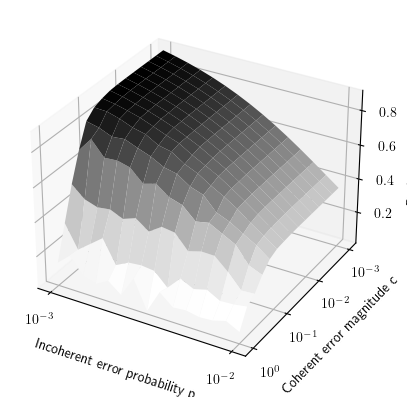

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.rcParams['text.usetex'] = True
X,Y = np.meshgrid(N,M)
ax.plot_surface(np.log10(Y), -np.log10(X), Z, rstride=1, cstride=1, cmap='Greys')
ax.set_xlabel("Incoherent error probability p")
ax.set_ylabel("Coherent error magnitude c")
ax.set_zlabel(r"Purity Tr$( \rho_1\rho_2)$")
ax.set_yticks([3,2,1,0])
ax.set_yticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$'])
ax.set_xticks([-3,-2,])
ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$'])

#fig.savefig("coherent_not_corrected.pdf")

In [30]:
batch_size=15
M = np.logspace(-3, -2, batch_size)
N = np.logspace(-3, 0, batch_size)
Z = nnp.zeros((batch_size,batch_size))

for i,x in enumerate(M):
    for j,y in enumerate(N):
        Z[i,j] = np.real(fixed_func_opt(x,y))
print('Done')

before opt
(0.89736086+0j)
after opt
(0.89737153+0j)
before opt
(0.89735526+0j)
after opt
(0.8973774+0j)
before opt
(0.89731616+0j)
after opt
(0.8973583+0j)
before opt
(0.89734554+0j)
after opt
(0.8974013+0j)
before opt
(0.89725214+0j)
after opt
(0.8973674+0j)
before opt
(0.8970648+0j)
after opt
(0.8973718+0j)
before opt
(0.89647347+0j)
after opt
(0.89725655+0j)
before opt
(0.89265704+0j)
after opt
(0.89740264+0j)
before opt
(0.8947839+0j)
after opt
(0.89757264+0j)
before opt
(0.8839586+0j)
after opt
(0.89727485+0j)
before opt
(0.81783354+0j)
after opt
(0.8959042+0j)
before opt
(0.46763182+0j)
after opt
(0.892429+0j)
before opt
(0.26865587+0j)
after opt
(0.8976224+0j)
before opt
(0.00783831+0j)
after opt
(0.8715009+0j)
before opt
(0.124855496+0j)
after opt
(0.8813221+0j)
before opt
(0.8802817+0j)
after opt
(0.8802949+0j)
before opt
(0.88028395+0j)
after opt
(0.88029706+0j)
before opt
(0.8802878+0j)
after opt
(0.8803077+0j)
before opt
(0.8801977+0j)
after opt
(0.8802914+0j)
before opt
(

after opt
(0.57968146+0j)
before opt
(0.5724333+0j)
after opt
(0.5796282+0j)
before opt
(0.5303788+0j)
after opt
(0.58350104+0j)
before opt
(0.49055317+0j)
after opt
(0.57902175+0j)
before opt
(0.38266522+0j)
after opt
(0.582942+0j)
before opt
(0.42701825+0j)
after opt
(0.5766588+0j)
before opt
(0.021238003+0j)
after opt
(0.55690056+0j)
before opt
(0.52785236+0j)
after opt
(0.52806497+0j)
before opt
(0.52785045+0j)
after opt
(0.52805656+0j)
before opt
(0.52784425+0j)
after opt
(0.5280472+0j)
before opt
(0.5278769+0j)
after opt
(0.5280665+0j)
before opt
(0.52782696+0j)
after opt
(0.52801794+0j)
before opt
(0.52773076+0j)
after opt
(0.52805686+0j)
before opt
(0.52720064+0j)
after opt
(0.5280287+0j)
before opt
(0.52669924+0j)
after opt
(0.52806365+0j)
before opt
(0.5246792+0j)
after opt
(0.52749723+0j)
before opt
(0.5244061+0j)
after opt
(0.52780974+0j)
before opt
(0.51569647+0j)
after opt
(0.5292304+0j)
before opt
(0.51755446+0j)
after opt
(0.52725136+0j)
before opt
(0.20388284+0j)
after

[Text(-3, 0, '$10^{-3}$'), Text(-2, 0, '$10^{-2}$')]

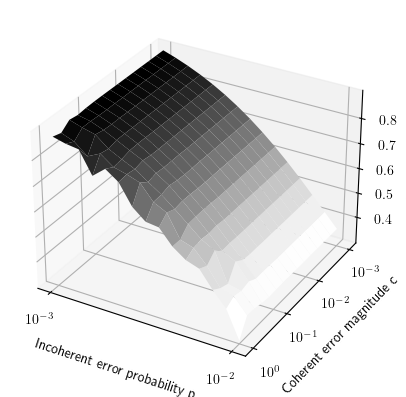

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.rcParams['text.usetex'] = True

X,Y = np.meshgrid(N,M)

ax.plot_surface(np.log10(Y), -np.log10(X), Z, rstride=1, cstride=1, cmap='Greys')
ax.set_xlabel("Incoherent error probability p")
ax.set_ylabel("Coherent error magnitude c")
ax.set_zlabel(r"Purity Tr$( \rho_1 \rho_2)$")
ax.set_yticks([3,2,1,0])
ax.set_yticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$'])
ax.set_xticks([-3,-2,])
ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$'])
#fig.savefig("coherent_corrected.pdf")